In [1]:
import pandas as pd #version -2.2.2
import numpy as np #version -1.25.0
import os
from tqdm import tqdm
from matplotlib import pyplot as plt
from pylab import mpl
from sklearn.linear_model import LinearRegression
import import_ipynb
from oss_handler import OssClient

importing Jupyter notebook from oss_handler.ipynb
importing Jupyter notebook from setting.ipynb
LTAI5tN7V51xtxUmaKxmRsWo rmqsMszRtvurcckVMD9M14riQYshi6 2nd-data oss-cn-shenzhen.aliyuncs.com


In [2]:
oss_client = OssClient()

## read_data

In [3]:
adj_close = oss_client.read_oss_pickle_file('ad_hoc_prod/fields_full/adj_close.pk')
adj_open = oss_client.read_oss_pickle_file('ad_hoc_prod/fields_full/adj_open.pk')
Close = oss_client.read_oss_pickle_file('ad_hoc_prod/fields_full/close.pk') 
Open = oss_client.read_oss_pickle_file('ad_hoc_prod/fields_full/open.pk') 

limit_down = oss_client.read_oss_pickle_file('ad_hoc_prod/fields_full/limit_down.pk') #跌停
limit_up = oss_client.read_oss_pickle_file('ad_hoc_prod/fields_full/limit_up.pk') #涨停

halt_status = oss_client.read_oss_pickle_file('ad_hoc_prod/fields_full/halt_status.pk') #停牌 
st_status = oss_client.read_oss_pickle_file('ad_hoc_prod/fields_full/st_status.pk') #st
st_status = st_status.replace(True,np.nan).replace(False,True)
halt_status = halt_status.replace(True,np.nan).replace(False,True)

adj_return =  adj_close/adj_close.shift(1) - 1
adj_return = adj_return.replace(np.inf,np.nan).replace(-np.inf,np.nan)
adj_return = adj_return[(adj_return.index >= '2017-01-01')]

idx = oss_client.read_oss_pickle_file('ad_hoc_prod/index_hist/000905.XSHG_hist_index.pkl').set_index('date')
idx_500_ret = (idx['close']/idx['close'].shift(1) - 1)

C:\Users\sensen.t\AppData\Local\Temp\ipykernel_8532\1920345502.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  st_status = st_status.replace(True,np.nan).replace(False,True)
C:\Users\sensen.t\AppData\Local\Temp\ipykernel_8532\1920345502.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  halt_status = halt_status.replace(True,np.nan).replace(False,True)


In [4]:
# adj_open = pd.read_pickle('D:/redata/fields_full/adj_open.pk')
# adj_close = pd.read_pickle('D:/redata/fields_full/adj_close.pk')
# Open = pd.read_pickle('D:/redata/fields_full/open.pk')
# Close = pd.read_pickle('D:/redata/fields_full/close.pk')

# ##正常交易非st，halt的票打1.其他为np.nan
# st_status = pd.read_pickle('D:/redata/fields_full/st_status.pk')
# halt_status = pd.read_pickle('D:/redata/fields_full/halt_status.pk')
# st_status = st_status.replace(True,np.nan).replace(False,True)
# halt_status = halt_status.replace(True,np.nan).replace(False,True)

# adj_return =  adj_close/adj_close.shift(1) - 1
# adj_return = adj_return.replace(np.inf,np.nan).replace(-np.inf,np.nan)

# ##csi500 idx
# idx = pd.read_pickle('D:/redata/idx/000905.XSHG_hist_index.pkl').set_index('date')
# idx_500_ret = (idx['close']/idx['close'].shift(1) - 1)

In [5]:
##调仓周期
# o1o2 = adj_open.shift(-2)/adj_open.shift(-1) - 1 #1日调仓

o1o2 = adj_open.shift(-5) / adj_open.shift(-1) - 1 #5日调仓 周频
# o1o2 = adj_open.shift(-10) / adj_open.shift(-1) - 1 #10日调仓
# o1o2 = adj_open.shift(-20) / adj_open.shift(-1) - 1 #20日调仓


ret_rank = o1o2.rank(axis=1,ascending=True)

## data_process

In [6]:
##剔除新股，st，halt，补全交易日  ###hist
def compute_condition(new_stk = 20):
    #上市不满60天的label
    drop_new_stk = adj_open.rolling(window=new_stk,min_periods=new_stk).mean()
    #drop_new_stk = drop_new_stk.dropna(how='all'，axis=1)
    drop_new_stk = ~np.isnan(drop_new_stk)  ##TorF
    df = st_status * halt_status * drop_new_stk
    df = df.replace(True,1).replace(False,np.nan)
    return df.loc['2017':]

In [7]:
##行业中性 2023.8.3 更新
def neturalize_ind(factor,risk,risk_cols):
    XY = pd.merge(risk, factor, on=['date', 'ticker'], how='right')
    print(XY.head(3))
    XY = XY.dropna()
    tradeday = XY.date.unique()
    daily_resid = []
    for date in tqdm(tradeday[:]):
        xy = XY[XY['date'] == date]
        #只保留有因子值的数据
        xy = xy.dropna()

        #数据标准化
        xy[risk_cols] = (xy[risk_cols] - xy[risk_cols].mean())/xy[risk_cols].std()                
        xy['factor'] = (xy['factor']-xy['factor'].mean())/xy['factor'].std() 

        #选出x y
        x = xy.iloc[:,2:-1]
        y = xy['factor']
        #回归
        multi_linear = LinearRegression(fit_intercept=False)  #无截距项
        multi_linear.fit(x, y)
        beta = multi_linear.coef_
        
        #取残差
        xy['beta'] = np.dot(x, beta)
        xy['resid'] = xy['factor'] - xy['beta']
        daily_resid.append(xy)
    data = pd.concat(daily_resid)
    factor = data[['date', 'ticker', 'factor', 'resid']]
    return factor

In [8]:
def factor_neutralize(df,factor_type,if_rank=True,risk=None,risk_cols=None): #factor_type=hist原值；ind行业及其他中性；单个风险因子文件名； if_rank：中性化之前时候对因子做rank处理
    #中性之前是否对因子做rank处理
    if if_rank == True:
        df = df.rank(axis=1, ascending=True)  # 原值越大rank值越大   
    #因子原值
    if factor_type == 'hist':
        factor_rank = df.copy()
    #行业市值中性
    elif factor_type == 'ind':  ###行业和风格中性
        def neu_process(df):
            df = df.stack().reset_index()
            df.columns = ['date','ticker','factor']
            df = neturalize_ind(df,risk,risk_cols)
            resid = df.set_index(['date','ticker'])['resid'].unstack()
            return resid        
        factor_rank = neu_process(df)
        factor_rank = factor_rank.rank(axis=1,ascending=True) 
        
    return factor_rank

In [9]:
def select_num_stocks(n):
    select_stocks = (factor_rank <= n)
    select_stocks_last = select_stocks.iloc[-1:,]
    select_stocks_last = select_stocks_last.replace(True,1).replace(False,np.nan)
    select_stocks_last = select_stocks_last.dropna(how='all',axis=1)
    return select_stocks_last

In [10]:
##因子中性化 需要的数据
risk1 = pd.read_pickle('D:/redata/risk_factors/logcmv.pkl')
risk2 = pd.read_pickle('D:/redata/risk_factors/retsum120.pkl')
ind = pd.read_pickle('D:/redata/risk_factors/ind_label.pkl')
# ind = pd.read_pickle('D:/redata/risk_factor/ind_label.pk')
risk = risk1.merge(risk2,on=['date','ticker'],how='left')
risk = risk.merge(ind,on=['date','ticker'],how='left')
risk = risk[(risk['date']>'2017-01-01')]
risk = risk.drop_duplicates(keep='last')

In [11]:
##剔除10日内新股，st，halt
final_universe = compute_condition(new_stk = 10) 

C:\Users\sensen.t\AppData\Local\Temp\ipykernel_8532\3828553184.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(True,1).replace(False,np.nan)


## factor part

In [12]:
    # 'D:/redata/Neutraliza/turnoverate@nu.pkl', (换手太高）
    # 'D:/redata/Neutraliza/turnover_umr@nu.pkl', (换手太高）
    # 'D:/redata/Neutraliza/ret_20@nu.pkl',(换手太高）
    # 'D:/redata/Neutraliza/ret20rolling@nu.pkl',（没*-1，换手太高）
    # 'D:/redata/Neutraliza/AOGrolling@nu.pkl',（垃圾）
    # 'D:/redata/Neutraliza/JOR@nu.pkl',（垃圾）
    # 'D:/redata/Neutraliza/ON20@nu.pkl',（没*-1，改进）
    # 'D:/redata/Neutraliza/IN20@nu.pkl',（没*-1，改进）


    # 'D:/redata/Neutraliza/Mom6m@nu.pkl',(换手太高）
    # 'D:/redata/Neutraliza/Mom12m@nu.pkl',改进
    # 'D:/redata/Neutraliza/Mom36m@nu.pkl',改进
    # 'D:/redata/Neutraliza/MaxRet@nu.pkl',没*-1 改进

    # 'D:/redata/Neutraliza/std_turn@nu.pkl',没*-1 优秀
    # 'D:/redata/Neutraliza/VolSD@nu.pkl', 没*-1 优秀 改进
    # 'D:/redata/Neutraliza/Momss@nu.pkl', 没*-1 差
    # 'D:/redata/Neutraliza/turnover_std@nu.pkl', 优秀 收益高波动大
    # 'D:/redata/Neutraliza/turnrate_mean@nu.pkl', 优秀 更稳定
    # 'D:/redata/Neutraliza/mv@nu.pkl',
    # 'D:/redata/Neutraliza/alpha95@nu.pkl', 差
    # 'D:/redata/Neutraliza/currentdebtodebt@nu.pkl',改进
    # 'D:/redata/Neutraliza/maketcap@nu.pkl',
    # 'D:/redata/Neutraliza/total_amount_5@nu.pkl', 没*-1差
    # 'D:/redata/Neutraliza/liquidity@nu.pkl', 优秀
    # 'D:/redata/Neutraliza/APB_20@nu.pkl', 优秀
    # 'D:/redata/Neutraliza/daily_standard_deviation@nu.pkl', 没*-1 优秀
    # 'D:/redata/Neutraliza/hml_r_std_6m@nu.pkl', 可用 一般
    # 'D:/redata/Neutraliza/hpl_r_std_6m@nu.pkl', 优秀
    # 'D:/redata/Neutraliza/william_lowershadow_mean@nu.pkl', 没*-1 换手太高
    # 'D:/redata/Neutraliza/adjclose@nu.pkl',
    # 'D:/redata/Neutraliza/uppershadow_std@nu.pkl', 没*-1 换手太高
    # 'D:/redata/Neutraliza/bias_5@nu.pkl', 没*-1 换手太高
    # 'D:/redata/Neutraliza/UBL@nu.pkl', 优秀
    # 'D:/redata/Neutraliza/net_profit_Q_yoy@nu.pkl', 优秀
    # 'D:/redata/Neutraliza/net_profit_parent_company_Q_yoy@nu.pkl', 优秀
    # 'D:/redata/Neutraliza/operating_revenue_Q_yoy@nu.pkl', 优秀
    # 'D:/redata/Neutraliza/operating_revenue_TTM@nu.pkl', 优秀
    # 'D:/redata/Neutraliza/BP@nu.pkl', 优秀
    # 'D:/redata/Neutraliza/EP@nu.pkl', 优秀
    # 'D:/redata/Neutraliza/cfp_ttm@nu.pkl', 优秀

In [13]:
df = pd.read_pickle('D:/redata/factor/zscore_volume@factor.pkl') ###读入因子值'Z:/Sen/comb_mean.pkl'
# df = df[(df.index>'2017-01-01')]
# df = df.rolling(5).mean()
# df = -df

In [14]:
# df = df.drop_duplicates()
# df

In [15]:
# df = pd.read_pickle('D:/redata/factor/comb_mean_sm.pkl')###读入因子值'Z:/Sen/comb_mean.pkl'
# df = df[(df.index >= '2024-01-01')]

In [16]:
# df = df.replace(np.inf,np.nan).replace(-np.inf,np.nan)

In [17]:
#剔除 新股 st halt
df_clean = (df * final_universe)
df_clean = df_clean.dropna(how='all',axis=0)

In [31]:
factor_type = 'hist'  # 'hist' 因子原值， 'ind' 对因子做行业中性
factor_rank = factor_neutralize(df_clean,factor_type,if_rank=True,risk=risk,risk_cols=['logcmv','retsum120']) 
factor_rank = factor_rank.drop_duplicates()

In [32]:
factor_rank

ticker,000001,000002,000004,000005,000006,000007,000008,000009,000010,000011,...,688787,688788,688789,688793,688798,688799,688800,688819,688981,689009
date,,,,,,,,,,,,,,,,,,,,,
2017-03-20,1886.0,NaN,2461.0,1610.0,797.0,NaN,2392.0,2032.0,1471.0,304.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-21,1905.0,NaN,2473.0,1624.0,758.0,NaN,2412.0,2014.0,1009.0,274.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-22,1918.0,NaN,2490.0,1626.0,780.0,NaN,2417.0,2037.0,1064.0,285.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-23,1943.0,NaN,2492.0,1615.0,754.0,NaN,2422.0,2044.0,1069.0,255.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-24,1950.0,NaN,2502.0,1543.0,1240.0,NaN,2371.0,2002.0,1044.0,694.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-18,4549.0,1288.0,1802.0,NaN,3567.0,2314.0,197.0,2565.0,3060.0,1889.0,...,4515.0,344.0,4542.0,1151.0,4354.0,4710.0,4066.0,2136.0,4222.0,4613.0
2025-02-19,4546.0,1328.0,1798.0,NaN,4039.0,2339.0,246.0,2651.0,3057.0,1971.0,...,4466.0,217.0,4547.0,1088.0,4338.0,4699.0,4088.0,1854.0,4223.0,4602.0
2025-02-20,4516.0,1321.0,1681.0,NaN,4098.0,2243.0,245.0,2631.0,2941.0,1938.0,...,4519.0,226.0,4542.0,1069.0,4350.0,4669.0,3997.0,1828.0,4224.0,4589.0


In [33]:
ret_rank

ticker,000001,000002,000004,000005,000006,000007,000008,000009,000010,000011,...,688787,688788,688789,688793,688798,688799,688800,688819,688981,689009
date,,,,,,,,,,,,,,,,,,,,,
2014-01-02,1096.0,383.5,2243.0,1140.0,125.0,2209.0,179.0,585.0,154.0,298.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-03,1847.0,921.0,2243.0,1580.0,42.0,1957.0,86.0,891.0,996.0,596.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-06,2107.0,1598.0,189.5,969.0,300.0,1944.0,861.0,824.0,1304.0,299.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-07,1855.0,1227.0,338.0,862.0,632.0,1053.0,2046.0,1198.0,926.0,411.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-08,1754.0,819.0,188.0,1081.0,966.5,211.0,2328.0,1431.0,265.0,596.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-04-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-04-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
# factor_rank.count(axis = 1).plot()

In [35]:
select_num_stocks(n=20)

C:\Users\sensen.t\AppData\Local\Temp\ipykernel_8532\3449027321.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  select_stocks_last = select_stocks_last.replace(True,1).replace(False,np.nan)


ticker,000967,002044,002065,300019,300490,300946,301196,301238,600126,600633,600884,601177,603209,603956,605255,688151,688316,688393,688611,688719
date,,,,,,,,,,,,,,,,,,,,
2025-02-24,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


## result

### 1.IC

In [36]:
def compute_IC(factor_rank):
    IC = (factor_rank.corrwith(ret_rank,axis=1)).dropna()
    IC_mean = IC.mean()
    IC_std = IC.std()
    ICIR = IC_mean / IC_std
    ICres = pd.DataFrame([[IC_mean,ICIR]],columns=['ICmean','ICIR'])
    return IC,ICres

In [37]:
IC,ICres = compute_IC(factor_rank)

#### 波动惩罚滚动ICIR

In [38]:
# ICIR_120_weight = IC.rolling(120).apply(lambda x: x.mean()/x.std()).dropna()
# ICIR_120_weight.plot(figsize=(18,9))
# plt.show()

In [39]:
# ICIR_120_weight.to_pickle('D:/redata/icir/adjclose_icir.pkl')

<Axes: title={'center': 'rankIC0.0332 ICIR0.3827'}, xlabel='date'>

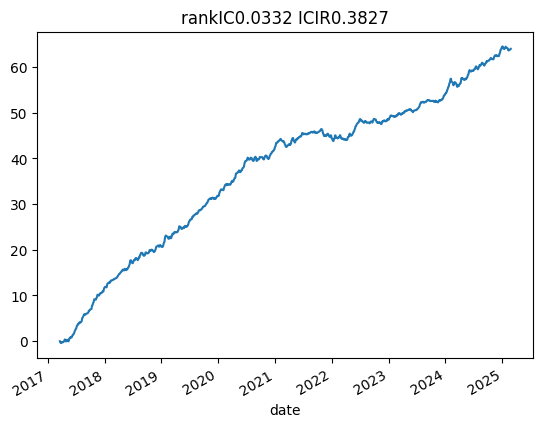

In [40]:
ic_title = 'rankIC'+str(round(ICres['ICmean'][0],4))+' ICIR'+str(round(ICres['ICIR'][0],4))
IC.cumsum().plot(title=ic_title)

abs(rankIC)>0.05 & ICIR>0.5 为优解

### 2.绝对收益,10层pnl

In [41]:
def compute_yield(weight_all):###通用的 输入weight计算pnl
    intra_return_open = ((adj_close / adj_open  - 1) * (adj_return.notnull() * 1.0).replace(0,np.nan)).replace(np.inf,np.nan).replace(-np.inf,np.nan)
    on_return_open = ((adj_return - intra_return_open) * (adj_return.notnull() * 1.0).replace(0,np.nan)).replace(np.inf,np.nan).replace(-np.inf,np.nan)
    # on_return_open = (((adj_open/adj_close.shift(1))-1)* (adj_return.notnull() * 1.0).replace(0,np.nan)).replace(np.inf,np.nan).replace(-np.inf,np.nan)
    
    turnover = (weight_all.replace(np.nan,0) - weight_all.replace(np.nan,0).shift(1)).dropna(how='all',axis=0).abs().sum(axis=1)
    n_shift = 1

    pnl_intra = ((weight_all).shift(n_shift) * intra_return_open).sum(axis=1)  
    pnl_on = ((weight_all).shift(n_shift + 1) * on_return_open).sum(axis=1)

    pnl = pnl_intra + pnl_on
    tcost =  turnover * 12 /(100*100)
    return pnl,tcost,turnover

def compute_abs_pnl(factor_rank):###计算分层收益
    dailyret = pd.DataFrame()
    dailyret_net = pd.DataFrame()
    turnover5 = []
    IC = []

    n_range = 10
    for layer in (range(n_range)):  # range(n_range):
        layer = layer + 1

        if layer == n_range:  # 最后一层，取值是取界限的闭区间
            weight1 = factor_rank.ge(factor_rank.max(axis=1) * (1 / n_range) * (layer - 1),axis=0)
        else:  # 前面几层都是左闭右开
            weight1 = (factor_rank.ge(factor_rank.max(axis=1) * (1 / n_range) * (layer - 1),axis=0)) & (factor_rank.lt(factor_rank.max(axis=1) * (1 / n_range) * (layer),axis=0))

        weight_all = (weight1.div(weight1.abs().sum(axis=1), axis=0)).replace(np.nan,0)  # 等权
        ####
       
        pnl,tcost,turnover = compute_yield(weight_all)
        
        dailyret['dailyret' + str(layer)] = pnl
        dailyret_net['dailyret' + str(layer)] = pnl - tcost
        turnover5.append(turnover.mean())

    # 去掉了因子值的第一天，少了最后一天
    start_date = factor_rank.index[1]
    end_date = factor_rank.index[-1] 
    dailyret = dailyret.loc[start_date:end_date]
    dailyret_net = dailyret_net.loc[start_date:end_date]
    return dailyret,dailyret_net,turnover5

In [42]:
dailyret,dailyret_net,turnover5 = compute_abs_pnl(factor_rank) 

In [43]:
def compute_factor_uni_ret():
    uni = ~np.isnan(factor_rank)
    weight_uni = uni.div(uni.sum(axis=1),axis=0)
    factor_uni_ret,_,_ = compute_yield(weight_uni)
    return factor_uni_ret

#年化收益
def evaluation(dailyret):
    # SHARP
    sharp = np.mean(dailyret, axis=0) / np.std(dailyret, axis=0) * np.sqrt(243)
    sharp = pd.DataFrame(sharp).T
    sharp.columns = [i.replace('dailyret', 'sharp') for i in sharp.columns]

    #年化收益
    yearly = dailyret.mean()*243
    yearly = pd.DataFrame(yearly).T
    yearly.columns = [i.replace('dailyret', 'yearly') for i in yearly.columns]
    
    # TURNOVER
    turnover = pd.DataFrame(turnover5).T
    turnover.columns = ['turn' + str(i + 1) for i in turnover.columns]
    result = pd.concat([sharp, yearly,turnover], axis=1)
    return result.T
def excess_evaluation(excess_pnl,excess_net_pnl):
    res = evaluation(excess_pnl)
    res_net = evaluation(excess_net_pnl)
    res_all = pd.concat([res, res_net], axis=1)
    res_all.columns = ['res','res_net']
    return res_all
def pic(pnl,uni):
    plt.figure(figsize=(12, 7))
    plt.title(factor_name+uni, color='blue')
    plt.plot(pnl.index, pnl['dailyret1'].cumsum(), color='r', linestyle='-')
    plt.plot(pnl.index, pnl['dailyret2'].cumsum(), color='y', linestyle='-')
    plt.plot(pnl.index, pnl['dailyret3'].cumsum(), color='b', linestyle='-')
    plt.plot(pnl.index, pnl['dailyret4'].cumsum(), color='g', linestyle='-')
    plt.plot(pnl.index, pnl['dailyret5'].cumsum(), color='k', linestyle='-')
    plt.plot(pnl.index, pnl['dailyret6'].cumsum(), color='r', linestyle='--')
    plt.plot(pnl.index, pnl['dailyret7'].cumsum(), color='y', linestyle='--')
    plt.plot(pnl.index, pnl['dailyret8'].cumsum(), color='b', linestyle='--')
    plt.plot(pnl.index, pnl['dailyret9'].cumsum(), color='g', linestyle='--')
    plt.plot(pnl.index, pnl['dailyret10'].cumsum(), color='k', linestyle='--')
    plt.grid()
    #plt.savefig(os.path.join(save_path,'pic',factor_name+uni+'.png'))
def output_res(res_all,layer):
    res_sharp = (res_all.head(layer)).reset_index(drop=True)
    res_sharp.columns = ['sharp','sharp_net']
    res_ret = (res_all.head(int(layer*2)).tail(layer)).reset_index(drop=True)
    res_ret.columns = ['return','return_net']
    res_turnover = (res_all.tail(layer)).reset_index(drop=True)
    res_turnover = res_turnover[['res']].rename(columns={'res':'turnover'})
    res_all = pd.concat([res_sharp,res_ret,res_turnover],axis=1)
    res_all = res_all.reset_index()
    res_all['index'] = res_all['index']+1
    res_all = res_all.set_index(['index'])
    res_all = res_all[['sharp', 'return', 'sharp_net', 'return_net', 'turnover']]
    return res_all

### 3.根据universe算超额收益(相对csi500和股票池),超额收益pnl的评估结果，pic 分层收益图

#### 相对csi500的超额收益

In [44]:
# ##相对csi500的超额收益
# benchmark = 'csi500'
# ##compute
# excess_pnl = dailyret.sub(idx_500_ret,axis=0)#.dropna(how='all',axis=0)
# excess_net_pnl = dailyret_net.sub(idx_500_ret,axis=0)#.dropna(how='all',axis=0)
# res_all = excess_evaluation(excess_pnl,excess_net_pnl)
# output_res(res_all,layer = 10)

In [45]:
# excess_pnl.loc[:].cumsum().plot(figsize=(12,8),grid=True,title='csi500_pnl')

#### 相对股票池组合的超额收益

In [46]:
benchmark = 'factor_uni'
factor_uni_ret = compute_factor_uni_ret() ###股票池的dailypnl 作为benchmark
##compute
excess_pnl = dailyret.sub(factor_uni_ret,axis=0)
excess_net_pnl = dailyret_net.sub(factor_uni_ret,axis=0)
res_all = excess_evaluation(excess_pnl,excess_net_pnl)

In [47]:
output_res(res_all,layer = 10)

,sharp,return,sharp_net,return_net,turnover
index,,,,,
1,-2.730563,-0.194220,-3.183675,-0.226475,0.110613
2,-0.706793,-0.029696,-2.367258,-0.099506,0.239403
3,-0.189167,-0.006130,-3.062024,-0.099105,0.318843
4,-0.401268,-0.010857,-4.465687,-0.120743,0.376837
5,0.295481,0.007043,-4.798441,-0.114029,0.415197
6,1.031955,0.023733,-4.491488,-0.103093,0.434932
7,1.355982,0.035636,-3.475340,-0.090904,0.433952
8,1.426606,0.046137,-2.243289,-0.072244,0.405969
9,1.588154,0.066055,-0.762231,-0.031623,0.334970


<Axes: title={'center': 'alluni_pnl'}, xlabel='date'>

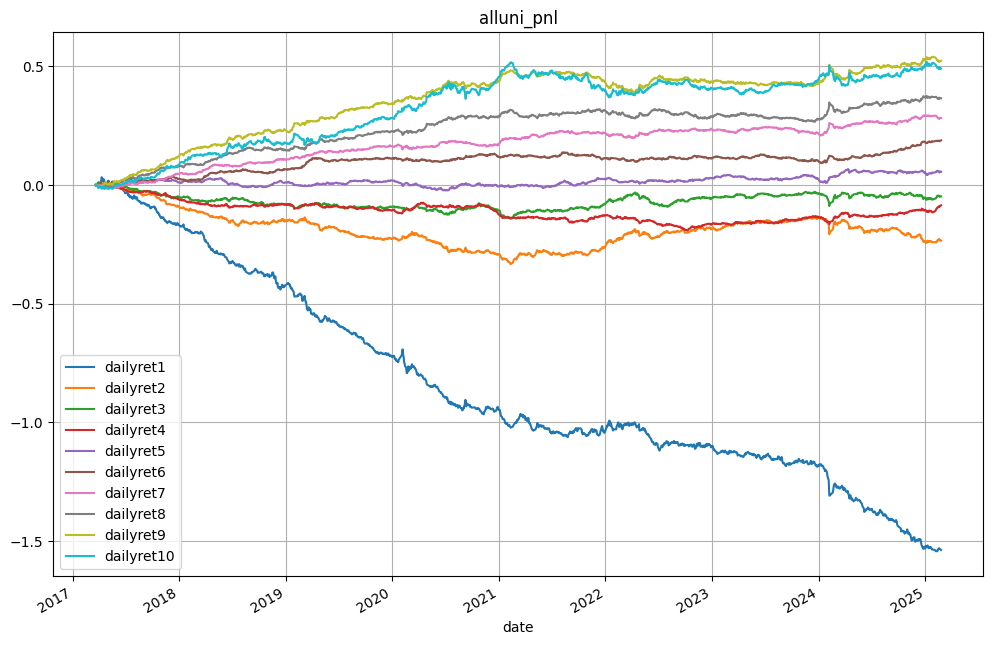

In [48]:
excess_pnl.loc[:].cumsum().plot(figsize=(12,8),grid=True,title='alluni_pnl')

### 4.单独看top10%组合，超额收益，以及每年表现

In [49]:
###top100， evalu
def comp_evaluation(pnl100_2):
    res = []
    year_ls = list(pd.DataFrame(pnl100_2.index)['date'].dt.year.unique())
    year_ls = [str(i) for i in year_ls]
    for year in year_ls:
        year_pnl100 = pnl100_2.loc[year]
        sharp = np.mean(year_pnl100) * np.sqrt(243) / np.std(year_pnl100)

        year_pnl100 = pnl100_2.loc[year]
        sumpnl = year_pnl100.sum()
        res.append(pd.DataFrame([[sharp.values[0],sumpnl.values[0]]],columns=['sharp', 'ret']))

    y = pd.concat(res)
    y.index = year_ls

    pnl100res_sum_sharp = pd.DataFrame((np.mean(pnl100_2) * np.sqrt(243)) / np.std(pnl100_2)).T
    pnl100res_sum_yearlymean = pd.DataFrame(pnl100_2.mean()*243).T


    y1 = pd.concat([pnl100res_sum_sharp,pnl100res_sum_yearlymean],axis=1)
    y1.columns = ['sharp', 'ret']
    y1.index = ['Yearly']

    y = pd.concat([y,y1])
    return y

In [52]:
def top10_comp(df):
    #top10%
    w = df.ge(df.max(axis=1) * args_quantile,axis=0) #top10
    #bottom 10%
    #w = df.le(df.max(axis=1) * args_quantile,axis=0)
    w100 =  (w.div(w.abs().sum(axis=1), axis=0)).replace(np.nan,0)#等权
    #w = (w*df).replace(0,np.nan).loc['2017-01-01':'2023-04-04']
    pnl,tcost,turnover100 = compute_yield(w100)
    pnl100 = pd.concat([pnl,pnl-tcost],axis=1).dropna()
    pnl100.columns = ['pnl','netpnl']
    #top100 超额dailypnl
    pnl100['excesspnl_csi500'] = pnl100['pnl'].sub(idx_500_ret,axis=0)
    pnl100['excessnetpnl_csi500'] = pnl100['netpnl'].sub(idx_500_ret,axis=0)
    pnl100['excesspnl_all'] = pnl100['pnl'].sub(factor_uni_ret,axis=0)
    pnl100['excessnetpnl_all'] = pnl100['netpnl'].sub(factor_uni_ret,axis=0)
    return pnl100,turnover100

In [53]:
turnover.mean()

NameError: name 'turnover' is not defined

In [ ]:
##结果，相对csi500

In [51]:
#因子原值
pnl_tp = 'excesspnl_csi500'
pnl100_2 = pnl100_hist[[pnl_tp]]
y1 = comp_evaluation(pnl100_2)
#因子原值
pnl_tp = 'excessnetpnl_csi500'
pnl100_2 = pnl100_hist[[pnl_tp]]
y2 = comp_evaluation(pnl100_2)
y2.columns = ['sharp_net','ret_net']

NameError: name 'pnl100_hist' is not defined

In [ ]:
# pd.concat([y1.T,y2.T])

In [ ]:
# pd.concat([pnl100_hist['excesspnl_csi500'].loc[:].rename('pnl').cumsum(),pnl100_hist['excessnetpnl_csi500'].loc[:].rename('netpnl').cumsum()],axis=1).plot()

In [ ]:
##结果，相对整个股票池

In [ ]:
factor_uni_ret = compute_factor_uni_ret() ###股票池的dailypnl 作为benchmark

In [ ]:
#因子原值
pnl_tp = 'excesspnl_all'
pnl100_2 = pnl100_hist[[pnl_tp]]
y1 = comp_evaluation(pnl100_2)
#因子原值
pnl_tp = 'excessnetpnl_all'
pnl100_2 = pnl100_hist[[pnl_tp]]
y2 = comp_evaluation(pnl100_2)
y2.columns = ['sharp_net','ret_net']

In [ ]:
y1

In [ ]:
pd.concat([y1.T,y2.T])

In [ ]:
pd.concat([pnl100_hist['excesspnl_all'].loc[:].rename('pnl').cumsum(),pnl100_hist['excessnetpnl_all'].loc[:].rename('netpnl').cumsum()],axis=1).plot(grid=True,title='alluni_top10%')

# 